# Polish Traffic Sign Recognition

Lib import

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# import skimage.data
import skimage.transform
from skimage import io

import tensorflow as tf

import random
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


%matplotlib inline

Num GPUs Available:  0


Check our directories

In [2]:
print(os.listdir("./data"))

['labels.csv', 'test', 'train']


In [3]:
print(os.listdir("./data/train"))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91']


In [4]:
print(os.listdir("./data/test"))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91']


Parse and load trening data

In [5]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".jpg")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            #print(f)
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels

In [6]:
train_data_dir = "./data/train"
test_data_dir = "./data/test"

images, labels = load_data(train_data_dir)

Check data


In [7]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 92
Total Images: 16746




Display the first image of each label.


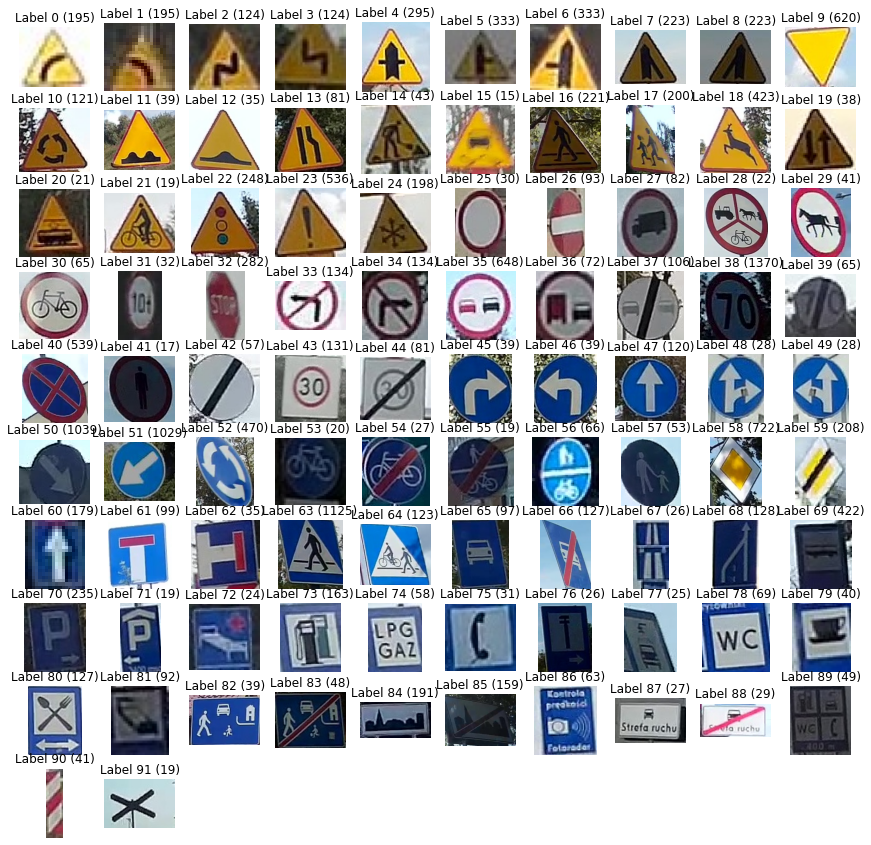

In [8]:
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(10, 10, i) # X - Y
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

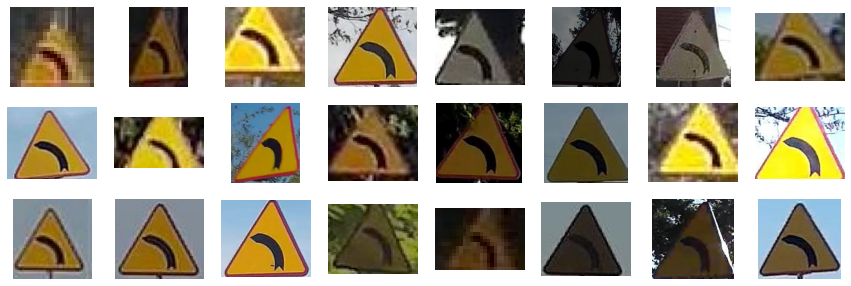

In [9]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # max 24
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 x 8
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 1)

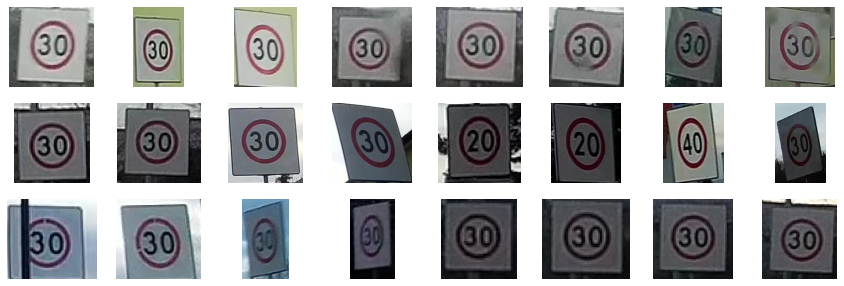

In [10]:
display_label_images(images, 43)

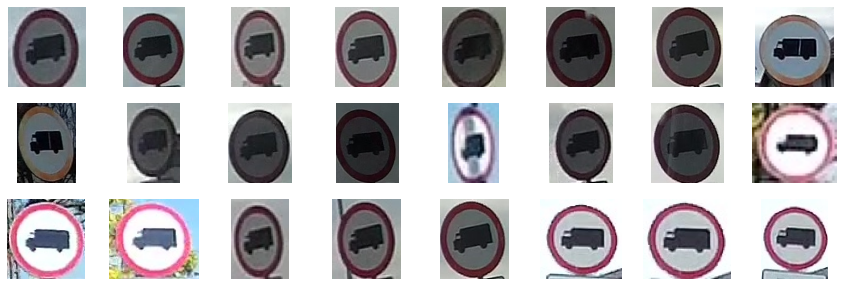

In [11]:
display_label_images(images, 27)

What is image size?

In [12]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (21, 25, 3), min: 0, max: 255
shape: (44, 48, 3), min: 0, max: 237
shape: (67, 75, 3), min: 0, max: 170
shape: (53, 61, 3), min: 0, max: 164
shape: (213, 194, 3), min: 0, max: 166


Change all images size to 32x32

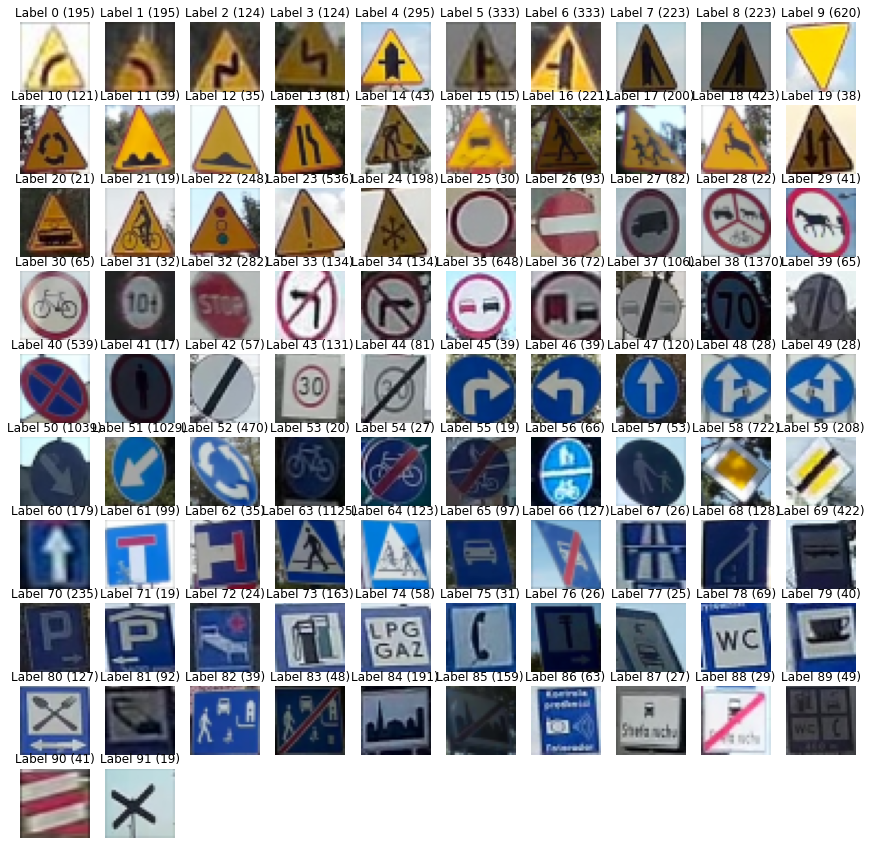

In [13]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

Check sizes and min and max also. It's betweeen 0 and 1.

In [14]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0014562270220588236, max: 1.0
shape: (32, 32, 3), min: 0.006222986792754482, max: 0.8895056195284579
shape: (32, 32, 3), min: 0.0008840199415049955, max: 0.6054150829021877
shape: (32, 32, 3), min: 0.0025295513781674406, max: 0.4710136721054689
shape: (32, 32, 3), min: 0.00500211772342066, max: 0.5632259672684413


# Model building

In [15]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (16746,) 
images:  (16746, 32, 32, 3)


In [16]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.compat.v1.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.compat.v1.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.compat.v1.layers.flatten(images_ph)

    # Fully connected layer.
    # Generates logits of size [None, 92]
    logits = tf.compat.v1.layers.dense(images_flat, 92, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(input=logits, axis=1)

    # Define the loss function.
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(input_tensor=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.compat.v1.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

C:\Users\Szymon\AppData\Local\Temp\ipykernel_13668\2291159152.py:12: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  images_flat = tf.compat.v1.layers.flatten(images_ph)
C:\Users\Szymon\AppData\Roaming\Python\Python39\site-packages\keras\legacy_tf_layers\core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\Szymon\AppData\Local\Temp\ipykernel_13668\2291159152.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.compat.v1.layers.dense(images_flat, 92, tf.nn.relu)
C:\Users\Szymon\AppData\Roaming\Python\Python39\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.


images_flat:  Tensor("flatten/Reshape:0", shape=(None, 3072), dtype=float32)
logits:  Tensor("dense/Relu:0", shape=(None, 92), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(None,), dtype=int64)


# Training

In [17]:
# Create a session to run the graph we created.
session = tf.compat.v1.Session(graph=graph)

# First step is always to initialize all variables.
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [18]:
for i in range(201):
    _, loss_value = session.run([train, loss],
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.544602
Loss:  3.395774
Loss:  2.9807417
Loss:  2.742397
Loss:  2.5944076
Loss:  2.4919794
Loss:  2.415221
Loss:  2.354692
Loss:  2.3050058
Loss:  2.263082
Loss:  2.227041
Loss:  2.195565
Loss:  2.1677198
Loss:  2.1428676
Loss:  2.1204877
Loss:  2.100183
Loss:  2.0816643
Loss:  2.064685
Loss:  2.049042
Loss:  2.0345657
Loss:  2.021112


## Using the Model


In [19]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[17, 38, 54, 52, 51, 54, 51, 23, 6, 58]
[17 38 70 52 51 40 51 23  5 58]


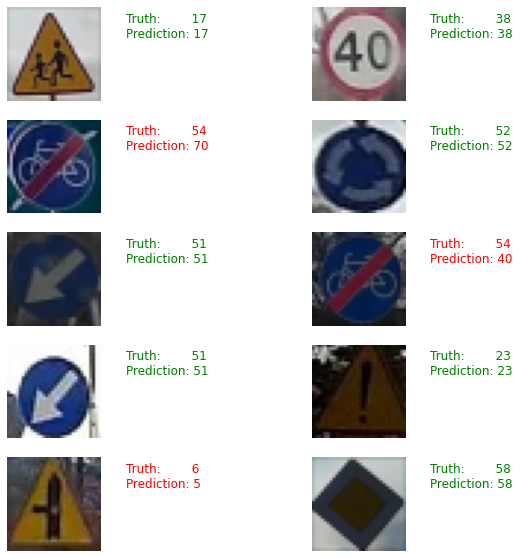

In [20]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

## Check accuracy of model by testing on test data

In [21]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

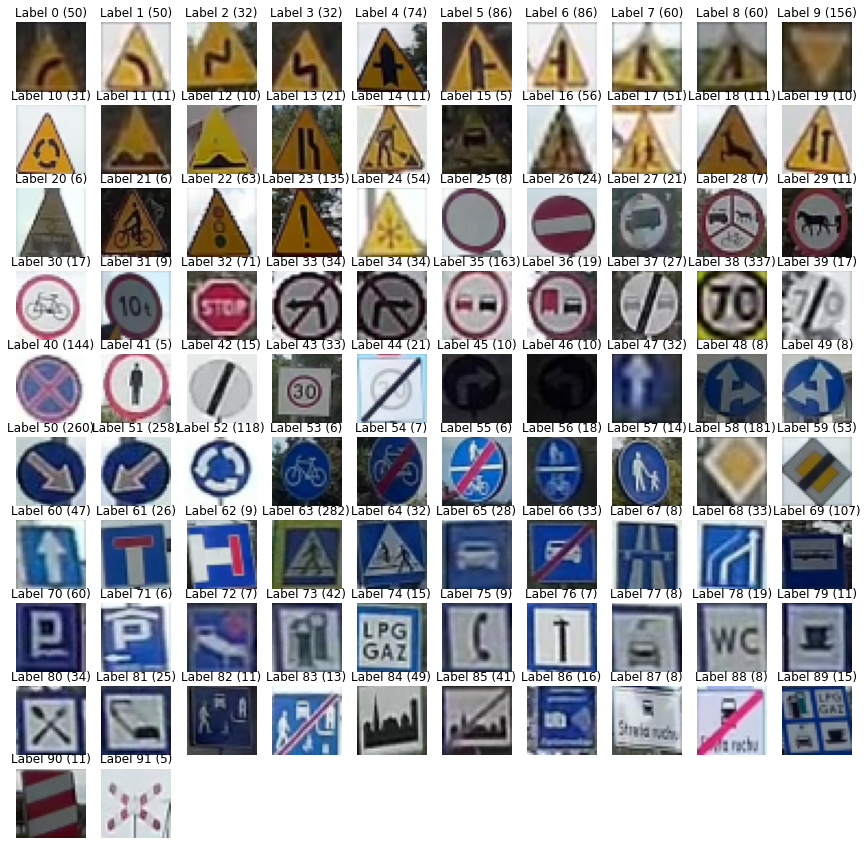

In [22]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [23]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels],
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.564


In [24]:
# Close the session. This will destroy the trained model.
session.close()